In [1]:
!echo "hello"

hello


# load and view data

In [1]:
from __future__ import print_function, division
from collections import OrderedDict
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


x = np.load('data/gsn_img_uint8.npy')
y = np.load('data/gsn_msk_uint8.npy')

x_test = np.load('data/test_gsn_image.npy')
y_test = np.load('data/test_gsn_mask.npy')

In [2]:
print(x.shape, y.shape)

(2000, 128, 128, 3) (2000, 128, 128, 1)


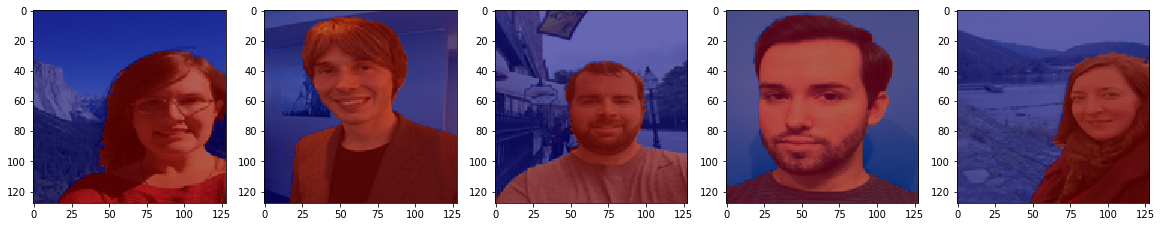

In [3]:
from matplotlib import pyplot as plt

def imshow(img):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img,aspect='auto')
    plt.show()

def imshow_many(imgs):
    n = imgs.shape[0]
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if(imgs.shape[3] == 1) :
            imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
        sub.imshow(imgs[i], interpolation='nearest')

def imshow_masked(samples):
    n = len(samples)
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        image = samples[i]['image']
        mask = samples[i]['mask']
        if torch.is_tensor(image) :
            image = image.permute(1,2,0)
        if torch.is_tensor(mask) :
            mask = mask.permute(1,2,0)
        mask = mask.reshape((mask.shape[0], mask.shape[1]))
        sub.imshow(image, interpolation='nearest')
        sub.imshow(mask, interpolation='nearest', cmap='jet', alpha=0.6)
    
start = 0
end = 5
samples = [{'image' : a, 'mask' : b} for a,b in zip(x[start:end], y[start:end])]
imshow_masked(samples)

# Transforms

In [38]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        resized_mask = transform.resize(mask, (new_h, new_w))
        mask = (resized_mask > 0.5).astype(resized_mask.dtype)

        return {'image': img, 'mask': mask}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask}


class HFlip(object):
    """Flip image horizontaly.
    """

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        return {'image': np.flip(image, 0), 'mask': np.flip(mask,0)}



class Rotate(object):
    """Flip image horizontaly.
    """

    def __init__(self, clockwise=True):
        self.cw = clockwise
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        if self.cw :
            img_CW = image.swapaxes(1,0)[:,::-1,...]
            mask_CW = mask.swapaxes(1,0)[:,::-1,...]
            sample = {'image': img_CW, 'mask': mask_CW}
        
        else :
            img_CCW = image.swapaxes(1,0)
            mask_CCW = mask.swapaxes(1,0)
            sample = {'image': img_CCW, 'mask': mask_CCW}

        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

# **Dataset**

In [39]:



class myDataset(Dataset):
    """Images and masks dataset."""

    def __init__(self, gsn_img, gsn_mask, transform=None):
        """
        Args:
            gsn_img (np.array): numpy array of images
            gsn_mask (np.array): numpy array of masks
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = gsn_img
        self.masks = gsn_mask
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        mask = self.masks[idx]

        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample


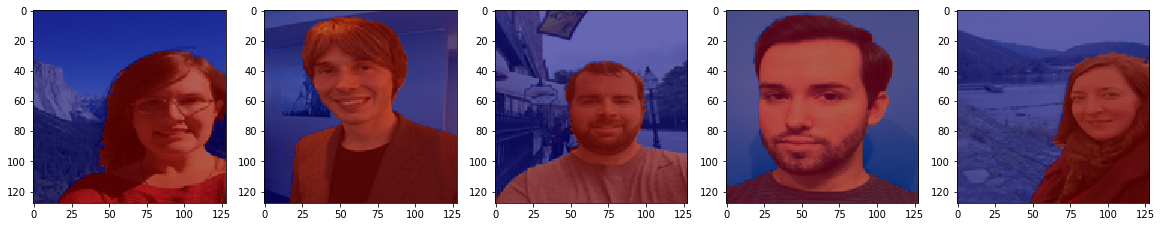

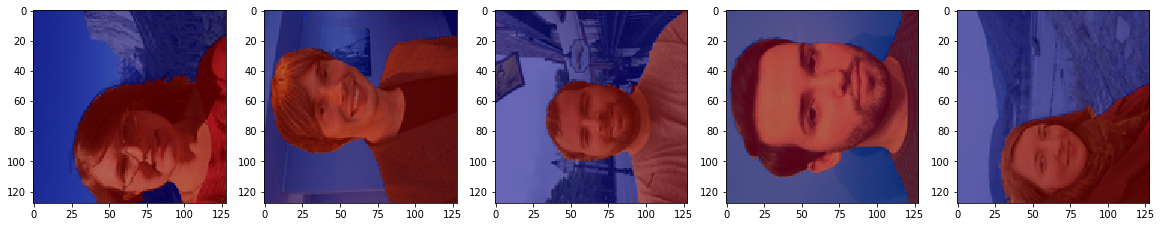

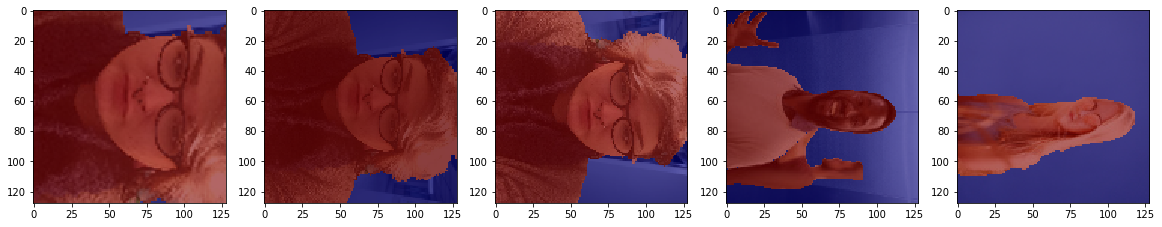

In [40]:
flip = HFlip()
scale = Rescale(256)
crop = RandomCrop(127)
rot_ccw = Rotate(False)
rot_cw = Rotate(True)
composed = transforms.Compose([Rescale(150),
                               RandomCrop(128),
                              ToTensor(),
                              ])

train_dataset = myDataset(x, y)
train_dataset_aug = myDataset(x, y, transform=rot_ccw)
test_dataset = myDataset(x_test, y_test, transform=rot_cw)

imshow_masked([train_dataset[i] for i in range(5)])

imshow_masked([train_dataset_aug[i] for i in range(5)])
imshow_masked([test_dataset[i] for i in range(5)])


In [15]:
trainloader = DataLoader(train_dataset_aug, batch_size=4,
                        shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# Network

In [51]:

torch.set_default_tensor_type(torch.cuda.DoubleTensor)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Training

In [57]:
epochs = 10
lr = 0.0001


def IOU(preds, truth):
    intersection = np.logical_and((preds > 0.5) == True,(truth > 0.5) == True).sum().item()
    union = (np.logical_or((preds > 0.5),(truth > 0.5))).sum().item()
    return intersection/union



def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))



class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

unet = UNet(in_channels=3, out_channels=1)

def train_validate():
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    unet.to(device)
    
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    
    loss_train = []
    loss_valid = []
    
    dsc_loss = DiceLoss()
    
    step = 0
    
    for epoch in range(epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()
    
            validation_pred = []
            validation_true = []
    
            for i, data in enumerate(trainloader, 0):
                if phase == "train":
                    step += 1
                
                x = data['image']
                y_true = data['mask']
                
                x, y_true = x.to(device), y_true.to(device)
    
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    
                    loss = dsc_loss(y_pred, y_true)
                    
                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
    
            if phase == "train":
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                log_loss_summary(loss_valid, epoch, prefix="val_")
                loss_valid = []
    
    

    
    
    


In [58]:
train_validate()

epoch 1 | loss: 0.2866535691415443
epoch 1 | val_loss: 0.21549801876867697
epoch 2 | loss: 0.18973931675266453
epoch 2 | val_loss: 0.1654355046093974
epoch 3 | loss: 0.138073294059205
epoch 3 | val_loss: 0.10994152670758757
epoch 4 | loss: 0.10309419352631854
epoch 4 | val_loss: 0.08498173816920837
epoch 5 | loss: 0.08090534115972617
epoch 5 | val_loss: 0.06449617856054929
epoch 6 | loss: 0.06478558479383265
epoch 6 | val_loss: 0.05317668648955214
epoch 7 | loss: 0.05308795668140759
epoch 7 | val_loss: 0.04619692593113742
epoch 8 | loss: 0.046447000125379515
epoch 8 | val_loss: 0.03766044423400287
epoch 9 | loss: 0.041414133472848634
epoch 9 | val_loss: 0.03846418663325275
epoch 10 | loss: 0.03705206659742876
epoch 10 | val_loss: 0.0320452103982743


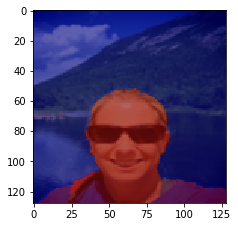

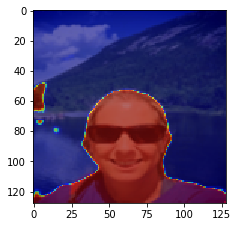

In [82]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")


dataiter = iter(trainloader)
one_data = dataiter.next()
image = one_data['image'].to(device)
y_true = one_data['mask'].to(device)
y_pred = unet(image)

imshow_masked([{'image':image[0].cpu(), 'mask':y_true[0].cpu()}])
imshow_masked([{'image':image[0].cpu(), 'mask':y_pred[0].detach().cpu()}])
# print(train_dataset_aug[0]['image'].shape, y_true[0].shape)

In [68]:
torch.cuda.is_available()

True